1. Read all the TSV files into an array, write a function to extract the title and authors data
2. Go through each TSV and use title and authors to search the OCLC for OWI number
3. Go through each OWI and get:
    3.1 Earliest year published
    3.2 Holdings
    3.3 For OWI with the most holdings: VIAF -> Genders
    3.5 For each OWI where "book" in .get("format")
    Make Genders -> DDC dict, add to it manually
4. Make a dict of TITLE/AUTHOR STRING -> OWI, YEAR_PUBLISHED, GENDER(S), TOP_DDC, FAST_LIST?

In [1]:
import csv, os
from datetime import datetime
f_filen = "tabula-1963-03-17.tsv"
nf_filen = "tabula-1963-03-17-nf.tsv"
data_i = 2 #How far into the tsv file the data shows up...
fields = ['rank','title+author','rank_last_week','weeks_on_list']
stop_words_authors = ["Others"]

# Read the Data In

In [3]:
def empty(row):
    if row[0]=="":
        return True
    return False 

def extract_date(datestr):
    try:
        date = datetime.strptime(datestr[0],'%B %d, %Y')
    except ValueError:
        try:
            date = datetime.strptime(datestr[0],'%B %d,%Y')
        except ValueError:
            datestr = input("Enter the date in %B %d, %Y format: ")
            date = datetime.strptime(datestr,'%B %d, %Y')
    return date

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def header(row):
    if is_number(row[0]):
        return False
    else:
        return True
    
def read_tsv(name):
    i = 0
    arr = []
    date = ""
    with open(name) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            if (header(row)) & (not empty(row)) & (i>data_i):
                return arr
            if i ==0 :
                date = extract_date([row[1]])
            if ((i > data_i) & (not empty(row))):
                arr.append([date]+row)
            i = i+1
        return arr
    
def read_folder(folderpath):
    arr = []
    for f in os.listdir(folderpath):
        commasv = read_tsv(folderpath+f)
        arr = arr+commasv
    return arr

eighty_path = "1980/"
eighty = read_folder(eighty_path)
for x in eighty[0:100]:
    print x

[datetime.datetime(1980, 2, 3, 0, 0), '1', "SMILEY'S PEOPLE, by John le Carr\xc3\xa9. (Knopf, $10.95.) The great British spy has", '1', '7']
[datetime.datetime(1980, 2, 3, 0, 0), '2', "THE DEVIL'S ALTERNATIVE, by Frederick Forsyth. (Viking, $12.95.) Countdown", '--', '1']
[datetime.datetime(1980, 2, 3, 0, 0), '3', 'JAILBIRD, by Kurt Vonnegut. (Delacorte/Seymour Lawrence, $9.95.) From World', '2', '20']
[datetime.datetime(1980, 2, 3, 0, 0), '4', 'TRIPLE, by Ken Follett. (Arbor House, $10.95.) Power play between intelligence', '4', '22']
[datetime.datetime(1980, 2, 3, 0, 0), '5', 'MEMORIES OF ANOTHER DAY, by Harold Robbins. (Simon & Schuster, $10.95.)', '5', '12']
[datetime.datetime(1980, 2, 3, 0, 0), '6', 'THE ESTABLISHMENT, by Howard Fast. (Houghton Mifflin, $11.95.) The', '7', '17']
[datetime.datetime(1980, 2, 3, 0, 0), '7', 'PRINCESS DAISY, by Judith Krantz. (Crown, $12.95.) The fight for survival in the', '--', '1']
[datetime.datetime(1980, 2, 3, 0, 0), '8', "SOPHIE'S CHOICE, by Wil

# Get Title and Author

In [4]:
# DONT DO IT THIS WAY parse_corrections = {}

In [20]:
#sample_title_auth = commasv[0][2]
#print sample_title_authR

#index into phrase to skip " by"
auth_i = 4

def parse_author_phrase(a_ph):
    authors = []
    end = len(a_ph)
    parens = a_ph.find("(")
    if parens != -1:
        end = parens-1
    auth_ph = a_ph[auth_i:end]
    if " and " in auth_ph:
        author_arr = auth_ph.split(" and ")
        for author in author_arr:
            if author[len(author)-1]=='.':
                author = author[:len(author)-1] # strip trailing period
            authors.append(author)
    else:
        author = auth_ph
        if author[len(author)-1]=='.':
            author = author[:len(author)-1] # strip trailing period
        authors.append(author)
    return authors

def title_author_pair(data_str):
    split_str = data_str.split(',')
    title = ""
    auth_ph = ""
    i=0
    t=True
    for phrase in split_str:    
        if i == 0:
            title = phrase
        else:
            if phrase.isupper() & t:
                title = title + ", "+phrase
            else:
                t = False
                auth_ph = auth_ph+phrase
        i = i+1
    authors = parse_author_phrase(auth_ph)
    return (title,authors)

for x in eighty:
    print title_author_pair(x[2])

("SMILEY'S PEOPLE", ['John le Carr\xc3\xa9'])
("THE DEVIL'S ALTERNATIVE", ['Frederick Forsyth'])
('JAILBIRD', ['Kurt Vonnegut'])
('TRIPLE', ['Ken Follett'])
('MEMORIES OF ANOTHER DAY', ['Harold Robbins'])
('THE ESTABLISHMENT', ['Howard Fast'])
('PRINCESS DAISY', ['Judith Krantz'])
("SOPHIE'S CHOICE", ['William Styron'])
('THE TOP OF THE HILL', ['Irwin Shaw'])
('PORTRAITS', ['Cynthia Freeman'])
("THE EXECUTIONER'S SONG", ['Norman Mailler'])
('THE DEAD ZONE', ['Stephen King'])
('THE LAST ENCHANTMENT', ['Mary Stewart'])
('THE THIRD WORLD WAR: August 1985', ['General Sir John Hackett', 'Other'])
('MOVIOLA', ['Garson Kanin'])
('THE BOURNE IDENTITY', ['Robert Ludlum'])
('PRINCESS DAISY', ['Judith Krantz'])
("THE DEVIL'S ALTERNATIVE", ['Frederick Forsyth'])
('THE BLEEDING HEART', ['Marilyn French'])
("SMILEY'S PEOPLE", ['John le Carr\xc3\xa9'])
("WHO'S ON FIRST", ['William F. Buckley Jr'])
('PORTRAITS', ['Cynthia Freeman'])
('NO LOVE LOST', ['Helen Van Slyke'])
("CREEK MARY'S BLOOD", ['Dee Br

# To OCLC


In [105]:
import xml.etree.ElementTree
import json
import urllib2
import re

ta_to_data_dict = {} 
oclc_base = "http://classify.oclc.org/classify2/Classify?"
alph = re.compile('[^a-zA-Z]')
suffixes = ['CPA', 'CSC', 'CSJ', 'DC', 'DD', 'DDS', 'DMD', 'DO', 'DVM', 'EDD', 'ESQ', 'II', 'III', 
            'IV', 'INC', 'JD', 'JR', 'LLD', 'LTD', 'MD', 'OD', 'OSB', 'PC', 'PE', 'PHD', 'RET', 
            'RGS', 'RN', 'RNC', 'SHCJ', 'SJ', 'SNJM', 'SR', 'SSMO', 'USA', 'USAF', 'USAFR', 'USAR', 
            'USCG', 'USMC', 'USMCR', 'USN', 'USNR']

In [93]:
def suffix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in suffixes:
        return True
    else:
        return False
    
def strip_punct(text):
    return alph.sub('', text)

def norm_text(text):
    return strip_punct(text).lower()

def url_to_data(url,f):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    if(f=="xml"):
        data = xml.etree.ElementTree.parse(res).getroot()
    if(f=="json"):
        data = json.load(res)
    return data

def convert_to_search(name):
    return_string = ""
    last_ch = " "
    for ch in name:
        if (ch == " "):
            if (last_ch != "."):
                return_string = return_string + "+"
        else:
            if ch == ".":
                return_string = return_string +".+"
            else:
                return_string = return_string+ch
        last_ch = ch
    return return_string

def last_name_recursive(name,last_index):
    if last_index == 0:
        return ""
    last_phrase = name[last_index]
    if not suffix(last_phrase):
        return last_phrase
    else:
        return last_name_recursive(name, last_index-1)

def last_name(name):
    names = name.split(" ")
    last_index = len(names)-1
    last = last_name_recursive(names,last_index)
    return last

def first_name(name):
    names = name.split(" ")
    return names[0]

In [28]:
from lxml import html
from bs4 import BeautifulSoup

viaf_base = "http://www.viaf.org/viaf/"
    
def get_gender_scrape(i):
    url = viaf_base+str(i)+"/"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"lxml")
    personal = soup.find('div',{'id':'personalinfo'})
    h4s = personal.find('h4')
    if (h4s is None) or (len(h4s)<5):
        return ""
    mt = []
    i=0
    for h in h4s:
        mt.append(h)
        i = i+1
    return mt[4]

Male


In [122]:
def is_book(w,t,a):
    if "book" in norm_text(w.get("format")):
        if norm_text(t) in norm_text(w.get("title")):
            for auth in a:
                if last_name(norm_text(auth)) in norm_text(w.get("author")):
                    return True
    return False

def find_all_works(xml,title,authors):
    works = xml.find('{http://classify.oclc.org}works')
    if works is None:
        works = []
        works.append(xml.find('{http://classify.oclc.org}work'))
        if (works is None) or works == []:
            return []        
    books = []
    for w in works:
        if is_book(w,title,authors):
            owi = w.get("owi")
            holdings = w.get("holdings")
            try:
                lyr = w.get("lyr")
            except:
                lyr = ""
            books.append({"owi":owi,"holdings":holdings,"lyr":lyr})
    return books

def new_work(w, entries):
    for e in entries:
        if w['owi'] == e["owi"]:
             return False
    return True

def get_oclc_entries(title,authors):
    url = oclc_base +"title="+convert_to_search(title)
    i = 0
    entries = []
    for a in authors:
        auth_url = url +"&author=" + last_name(a)
        xml = url_to_data(auth_url,"xml")
        try:
            works = find_all_works(xml,title,authors)
        except:
            return []
        if entries == []:
            entries = works
        else:
            for w in works:
                if new_work(w,entries):
                    entries = entries.append(w)
    return entries
    
print get_oclc_entries('BELOVED', ['Toni Morrison']) 

def max_holding(oarr):
    target = oarr[0]
    for o in oarr[1:]:
        if int(o['holdings'])>int(target['holdings']):
            target = o
    return target

def get_authors(xml):
    authors = xml.find('{http://classify.oclc.org}authors')
    target = []
    for a in authors:
        text = a.text
        v = a.get('viaf')
        target.append({'name':text, 'viaf':v})
    return target

def get_fast(xml):
    recs = xml.find('{http://classify.oclc.org}recommendations')
    target = []
    if recs is not None:
        fast = recs.find('{http://classify.oclc.org}fast')
        if fast is not None:
            headings = fast.find('{http://classify.oclc.org}headings')
            for h in headings:
                target.append(h.text)
    return target

def lookup_oclc(owi):
    url = oclc_base+"owi="+owi
    xml = url_to_data(url,"xml")
    v = get_authors(xml)
    fast = get_fast(xml)
    target = {'authors':v,'fast':fast}
    return target

test_author_dict = [{'viaf': '22619695', 'name': 'Bailey, Charles Waldo, 1929-2012 [Author]'}, {'viaf': '19720195', 'name': 'Knebel, Fletcher'}]

def get_genders(authors, viaf_dict):
    target = []
    for a in authors:
        v = get_viaf(a,viaf_dict)
        gender = get_gender_scrape(v)
        target.append({"name":a,"viaf":v,"gender":gender})
    return target
    
def get_viaf(author, viaf_dict_arr):
    l = norm_text(last_name(author))
    f = norm_text(first_name(author))
    target = ""
    for v in viaf_dict_arr:
        if l in norm_text(v['name']):
            target = v['viaf']
            if f in norm_text(v['name']):
                return v['viaf']
    return target

#print(get_genders(["Fletcher Knebel","Charles W. Bailey II"],test_author_dict))


[{'holdings': '13357', 'owi': '989794', 'lyr': '1987'}, {'holdings': '1899', 'owi': '149526417', 'lyr': '1987'}, {'holdings': '982', 'owi': '3768430774', 'lyr': '1998'}, {'holdings': '159', 'owi': '839489420', 'lyr': '2002'}, {'holdings': '61', 'owi': '1151679152', 'lyr': '1970'}, {'holdings': '27', 'owi': '4020568630', 'lyr': '2003'}, {'holdings': '4', 'owi': '301075038', 'lyr': '2001'}, {'holdings': '4', 'owi': '3092748', 'lyr': '????'}, {'holdings': '1', 'owi': '3375545245', 'lyr': '1988'}, {'holdings': '1', 'owi': '866836700', 'lyr': '2008'}]


In [277]:
def process_input_data(ta):       
    # if str(ta) not in ta_to_oclc_dict: CHECK FOR THIS OUTSIDE THE FN
    title = ta[0]
    author = ta[1]
    oclc = get_oclc_entries(title,author)
    if (oclc is None) or (len(oclc)<1):
        owi = []
        holdings = []
        year_pub = []
        fast_subjects = set()
        genders = []
    else:
        if len(oclc) == 1:
            primary = oclc[0]
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
        else:
            primary = max_holding(oclc)
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
            for o in oclc:
                if o['owi'] != primary['owi']:
                    other_data = lookup_oclc(o['owi'])
                    fast_subjects.update(other_data['fast'])
        owi = primary["owi"]
        year_pub = primary["lyr"]
        genders = get_genders(author, primary_data['authors'])
    return {"owi": owi, "year_pub": year_pub, "fast_subjects":fast_subjects, "genders":genders}

## need to add the original data (date, year, rankings) if this is the ultimate output
def process_raw_list(input_ls):
    target = []
    for row in input_ls:
        ta = title_author_pair(row[2])
        date = row[0]
        year = date.year
        target_row = {"date":date,"title":ta[0],"authors":ta[1],"year":year}
        string_ta = str(ta)
        if string_ta in ta_to_data_dict:
            target_row.update(ta_to_data_dict[string_ta])
        else:
            processed = process_input_data(ta)
            target_row.update(processed)
            ta_to_data_dict[string_ta] = processed
        target.append(target_row)
    return target

processed = process_raw_list(eighty)
print processed[0]

{'owi': '463023', 'title': "SMILEY'S PEOPLE", 'year': 1980, 'fast_subjects': set(['Smiley, George (Fictitious character)', 'Intelligence officers', 'Spy stories, English', 'Radio plays, English', 'Fiction', 'Intelligence service', 'Secret service', 'Adventure stories', 'English fiction', 'Great Britain', 'Radio plays', 'Spy stories']), 'year_pub': '1979', 'authors': ['John le Carr\xc3\xa9'], 'date': datetime.datetime(1980, 2, 3, 0, 0), 'genders': [{'gender': u'Male', 'viaf': '109254932', 'name': 'John le Carr\xc3\xa9'}]}


In [151]:
import pandas

terms = []
for x in processed:
    for y in x['fast_subjects']:
        if genre_candidate(y):
            terms.append(y)
    
term_series = pandas.Series(terms)
counts = term_series.value_counts()
print len(processed)
print(counts)

780
American fiction                           175
Spy stories                                141
English fiction                            138
Adventure stories                          137
Detective and mystery stories               88
Romance fiction                             75
Fiction                                     69
American literature                         54
Political fiction                           45
Suspense fiction                            40
Domestic fiction                            38
Horror tales                                34
Paranormal fiction                          34
Spy stories, American                       33
Suspense fiction, American                  33
English literature                          32
Historical fiction                          30
Legal stories                               27
Regimental histories                        26
Railroad stories                            26
Spy stories, English                        26
War stori

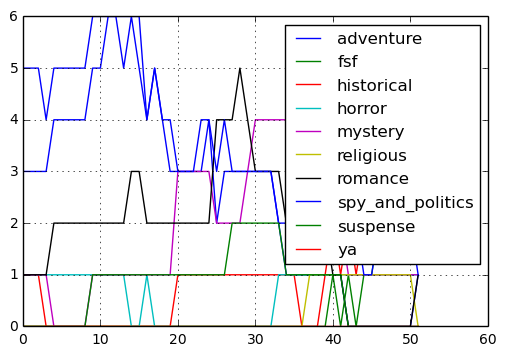

In [271]:
import matplotlib
%matplotlib inline

genre_terms = ["fiction","stories","tales","literature","opera"]
genre_dict = {"romance":{"keys":["romance","love","erotic","domestic"],"stops":["language"]},
              "suspense":{"keys":["suspense"]},
              "horror":{"keys":["horror","paranormal"]},
              "mystery":{"keys":["mystery","detective","crime"]},
              "spy_and_politics":{"keys":["spy","politic","war"]},
              "fsf":{"keys":["fantasy","science fiction", "space","cyberpunk","steampunk"]},
              "adventure":{"keys":["adventure","western","sea"]},
              "ya":{"keys":["young adult"]},
              "religious":{"keys":["religious","christian"],"stop":["aspects"]},
              "historical":{"keys":["historical"]} ## <-- I think this one might not be a well-supported
                                                   ## category in the DB
            }

def genre_candidate(fast_term):
    for term in genre_terms:
        if term in norm_text(fast_term):
            return True
    return False

def is_genre(fast_term,genre_str):
    terms = genre_dict[genre_str]['keys']
    if 'stops' in genre_dict[genre_str]:
        stops=genre_dict[genre_str]['stops']
    else:
        stops = []
    target = False
    for term in terms:
        if term in norm_text(fast_term):
            target = True
    for stop in stops:
        if stop in norm_text(fast_term):
            target = False
    return target

#def classify_genre(processed_row):
#    subjects = processed_row['fast_subjects']
def classify_genre(subjects):
    #print subjects
    target = {}
    for genre in genre_dict:
        target[genre]=0
    for subject in subjects:
        if genre_candidate(subject):
            for genre in genre_dict:
                if is_genre(subject,genre):
                    target[genre] = 1
    return target

def tally_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    return counts_dict

#classified = []
#for x in processed:
#    classified.append(classify_genre(x))
#print tally_genres(classified)


#df = pandas.DataFrame(processed)
#test_group = df.groupby(["date"])
#for g in test_group:
#    classified = []
#    print g[0]
#    y = test_group.get_group(g[0])
#    for z in y["fast_subjects"]:
#        classified.append(classify_genre(z))
#    print tally_genres(classified)    
    
def tally_genres_by_week(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        tallied = tally_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target
    
tall_df = pandas.DataFrame(tally_genres_by_week(processed,"date"))
tall_df.plot()

{'COME POUR THE WINE,  $12.95.) A': 'COME POUR THE WINE', 'THE CRADLE WILL FALL,  $10.95.) A': 'THE CRADLE WILL FALL', 'Norman Mailler': 'Norman Mailer', 'THE TENTH COMMANDMENT,  $11.95.) A': 'THE TENTH COMMANDMENT', 'THE SECOND COMING,  $12.95.) A': 'THE SECOND COMING'}
